In [1]:
import glob
import os
import numpy as np
import pandas as pd
import nltk

In [2]:
def get_data(split):
    if split.lower() == 'train':
        folder = 'train'
    elif split.lower() == 'test':
        folder = 'test'
    else:
        raise ValueError('Invalid data split specified.')
        
    file_names = []
    text = []
    is_positive = []
    
    # read all positive files
    files = glob.glob(os.path.join("data", folder, 'pos', '*'))
    for file in files:
        head, tail = os.path.split(file)
        file_names.append(tail)
        is_positive.append(1)
        with open(file, 'rb') as open_file:
            text.append(open_file.readlines()[0])
            
    # read all negative files
    files = glob.glob(os.path.join("data", folder, 'neg', '*'))
    for file in files:
        head, tail = os.path.split(file)
        file_names.append(tail)
        is_positive.append(0)
        with open(file, 'rb') as open_file:
            text.append(open_file.readlines()[0])
            
    return pd.DataFrame(data={'file': file_names, 'text': text, 'is_positive': is_positive})


train_df = get_data('train')
train_df['text'] = train_df['text'].astype(str)
train_df

,file,text,is_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1
...,...,...,...
24995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0
24996,9999_3.txt,b'This is the kind of movie that my enemies co...,0
24997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0
24998,99_1.txt,"b""Some films that you pick up for a pound turn...",0


### Get only 5000 records from the original 25000 highly polar movie reviews

In [3]:
positive_reviews = train_df[:2500]   #take first 2500 reviews which are positive
negative_reviews = train_df[22500:]  #last last 2500 reviews which are negative
new_train = positive_reviews.append(negative_reviews, ignore_index=True)


In [4]:
new_train

,file,text,is_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1
...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0


######  Tokenization is the process of breaking down chunks of text into smaller pieces.  Word tokenization separates text into individual words.
###### We will then filter out stop words to remove common English words such as "the", "and", "him" which will not be needed for modelling.

In [5]:
from nltk.corpus import movie_reviews #  this is the corpus we will use
from nltk.stem.snowball import SnowballStemmer #  Snowball stemmer > Porter stemmer
from nltk.tokenize.casual import casual_tokenize  # we use casual tokenize because this is colloquial text
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words  # sklearn stop words is larger than nltk

import re

stemmer = SnowballStemmer("english")
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def decontracted(phrase):
    # Taken from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def tokenize_phrase(text):
    phrase = decontracted(text.replace('\\', '').replace("b'", "")) # remove backslashes and replace contractions
    tokens = casual_tokenize(phrase, reduce_len=True, strip_handles=True)
    normalized_tokens = [x.lower() for x in tokens] #  convert to all lowercase
    filtered_tokens = [x for x in normalized_tokens if x not in sklearn_stop_words] #  filter stop words
    filtered_tokens = [x for x in filtered_tokens if x and x not in '- \t\n."\':[...][\\]()/[br]<>*~,;!?'] #  filter punctuations
    lemmatized_tokes = [lemmatizer.lemmatize(t) for t in tokens] # perform lemmatization
    stemmed_tokens = [stemmer.stem(w) for w in filtered_tokens] # perform stemming
    pos_tokens = nltk.pos_tag(stemmed_tokens) # perform part-of-speech tagging
    return pos_tokens



new_train['tokens'] = new_train['text'].apply(tokenize_phrase)
new_train


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Katrina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,file,text,is_positive,tokens
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,"[(bromwel, RB), (high, JJ), (cartoon, NN), (co..."
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,"[(homeless, NN), (houseless, NN), (georg, NN),..."
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,"[(brilliant, JJ), (over-act, JJ), (lesley, NN)..."
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,"[(easili, NN), (underr, JJ), (film, NN), (inn,..."
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,"[(typic, NN), (mel, NN), (brook, NN), (film, N..."
...,...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,"[(end, NN), (movi, NN), (felt, VBD), (technic,..."
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,"[(kind, NN), (movi, NN), (enemi, NN), (content..."
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,"[(saw, JJ), (descent, NN), (night, NN), (stock..."
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,"[(film, NN), (pick, NN), (pound, NN), (turn, V..."


Convert tokens to their own DataFrame so we can perform descriptive statistics on them.

In [6]:
import itertools

new_train['tokens_with_positive'] = new_train.apply(lambda x: [token + (x['is_positive'],) for token in x['tokens']], axis=1)
token_df = pd.DataFrame(list(itertools.chain.from_iterable(new_train['tokens_with_positive'])), columns=['token', 'part_of_speech', 'is_positive'])
token_df

,token,part_of_speech,is_positive
0,bromwel,RB,1
1,high,JJ,1
2,cartoon,NN,1
3,comedi,NN,1
4,ran,VBD,1
...,...,...,...
538085,time,NN,0
538086,money,NN,0
538087,wast,NN,0
538088,time,NN,0


Some descriptive statistics about the tokens

In [11]:
token_df[['token', 'is_positive']] \
    .groupby('token') \
    .count() \
    .rename(columns={'is_positive': 'count'}) \
    .sort_values(by=['count'], ascending=False)

,count
token,
movi,10057
film,9632
like,4492
just,3621
time,3217
...,...
one--h,1
one-and-a-half,1
one-and-a-half-hour,1


In [12]:
token_df[['part_of_speech', 'is_positive']] \
    .groupby('part_of_speech') \
    .count() \
    .rename(columns={'is_positive': 'count'}) \
    .sort_values(by=['count'], ascending=False)

,count
part_of_speech,
NN,301175
JJ,116896
VBP,27889
VBD,14881
RB,13626
VB,12327
NNS,10388
IN,10151
CD,8738


Normalization of words is condensing different forms of the same word into a single word. For example, "watched", "watching" and "watches" will be normalized to "watch".

Two main ways for normalization is through stemmming and lemmatization. In stemming, the common word endings such as "-ing", "s", "-ed", "-de" are removed from the smallest unit of the word. There may be some issues with words which have special conjugations, for example "feel" and "felt", since stemming just removes common word endings from the string. The relationship betwen "feel" and "felt" may not be recognized, and the stemming process may result in words which are not actual words.

Lemmatization uses a data structure to relate different forms of a word to its dictionary form or root word (lemma). Lemmatization will return an actual word in a language.

Modified from https://realpython.com/sentiment-analysis-python/


In [7]:
# describe categorical columns of token_df - unique, top and frequency of token and part-of-speech
token_df \
  .describe(include=np.object) \
  .transpose()

,count,unique,top,freq
token,792667,37958,.,56183
part_of_speech,792667,42,NN,283077


In [8]:
# group by positivity, count distinct pos and number of words
posneg_df = token_df.groupby('is_positive') \
           .agg({'part_of_speech': pd.Series.nunique,
                 'token': pd.Series.count}) \
           .rename(columns={'pos': 'pos_unique',
                            'token': 'token_count'}) \
           .sort_values('token_count', ascending=False)
            
# show top 5 records
posneg_df.head(5)

,part_of_speech,token_count
is_positive,,
1,42,401739
0,42,390928


In [9]:
# group by part-of-speech, count positivity rates and number of words by POS
pos_df = token_df.groupby('part_of_speech') \
           .agg({'is_positive': pd.Series.mean,
                 'token': pd.Series.count}) \
           .rename(columns={'is_positive': 'pos_rate',
                            'token': 'token_count'}) \
           .sort_values('token_count', ascending=False)
            
# show top 10 records
pos_df.head(10)

,pos_rate,token_count
part_of_speech,,
NN,0.516220,283077
JJ,0.516166,126068
.,0.488823,63524
NNP,0.481299,61654
",",0.521447,55718
RB,0.480163,34934
VBG,0.487200,25782
VBD,0.501943,23413
VB,0.492947,16093


In [8]:
#following tutorial from https://www.guru99.com/stemming-lemmatization-python-nltk.html

#Wordnet Lemmatizer (with Part of Speech tag)
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn     #import corpus reader wordnet
from nltk import word_tokenize, pos_tag   #import word_tokenize and parts of speech tag
from collections import defaultdict

#part of speech tag
tag_map = defaultdict(lambda : wn.NOUN)  #noun
tag_map['J'] = wn.ADJ    #adjective
tag_map['V'] = wn.VERB   #verb
tag_map['R'] = wn.ADV    #adverb

wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_phrase_no_stemming(text):
    phrase = decontracted(text.replace('\\', '').replace("b'", "")) # remove backslashes and replace contractions
    tokens = casual_tokenize(phrase, reduce_len=True, strip_handles=True)
    normalized_tokens = [x.lower() for x in tokens] #  convert to all lowercase
    filtered_tokens = [x for x in normalized_tokens if x not in sklearn_stop_words] #  filter stop words
    filtered_tokens = [x for x in filtered_tokens if x and x not in '- \t\n."\':[...][\\]()/[br]<>*~,;!?'] #  filter punctuations
    return tokens

tokens = tokenize_phrase(str(new_train['text'][2]))

for token, tag in pos_tag(tokens):
    lemma = wordnet_lemmatizer.lemmatize(token, tag_map[tag[0]])
    print(token, "=>", lemma)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Katrina\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Katrina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


brilliant => brilliant
over-act => over-act
lesley => lesley
ann => ann
warren => warren
best => best
dramat => dramat
hobo => hobo
ladi => ladi
seen => see
love => love
scene => scene
cloth => cloth
warehous => warehous
second => second
corn => corn
face => face
classic => classic
good => good
blaze => blaze
saddl => saddl
lawyer => lawyer
superb => superb
accus => accus
turncoat => turncoat
sell => sell
boss => bos
dishonest => dishonest
lawyer => lawyer
pepto => pepto
bolt => bolt
shrug => shrug
indiffer => indiffer
lawyer => lawyer
say => say
funni => funni
word => word
jeffrey => jeffrey
tambor => tambor
favorit => favorit
later => later
larri => larri
sander => sander
fantast => fantast
mad => mad
millionair => millionair
want => want
crush => crush
ghetto => ghetto
charact => charact
malevol => malevol
usual => usual
hospit => hospit
scene => scene
scene => scene
homeless => homeless
invad => invad
demolit => demolit
site => site
all-tim => all-tim
classic => classic
look => loo

# Visualization

In [10]:
our_text=token_df['token'] # may not work well yet

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

# Load the text data

vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(our_text)
features   = vectorizer.get_feature_names()

AttributeError: write not found

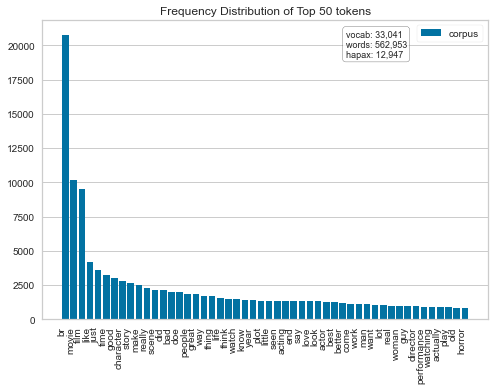

In [16]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show(docs)

In [9]:
#pre-processig with SpaCy
import spacy
nlp=spacy.load("en_core_web_sm")
doc=nlp(str(new_train['text']))

token_list=[token for token in doc] #tokenize

filtered_tokens=[token for token in token_list if not token.is_stop] #remove stop words - SpaCy is_stop includes punctuation and white space

lemmas = [f"Token: {token}, lemma:{token.lemma_}" for token in filtered_tokens] #lemmatization

lemmas

token_vec= [token.vector for token in filtered_tokens ]  #vectorize

#token_vec

[array([ 1.043978  ,  1.2941855 ,  1.0313386 , -1.0603244 , -0.7092614 ,
        -0.72790074,  0.09495676, -0.16269447,  0.02237374,  0.47874677,
        -0.06950757, -0.14419883,  0.5358865 ,  0.91357577,  1.0851387 ,
        -1.2436209 , -0.30215067,  1.9724283 ,  0.6704954 ,  0.8929903 ,
        -0.32862556,  0.519832  ,  0.6620741 ,  0.6167487 ,  0.51864797,
         0.17669389, -0.01274975,  0.32842684,  0.67096776, -0.36403096,
        -0.697662  , -1.7831767 , -0.2172007 , -0.7466278 ,  0.17290345,
         0.4427504 , -1.5653746 , -0.6315074 ,  0.11313256, -0.10127826,
        -1.1540408 ,  0.6654313 ,  1.7130609 ,  0.17737603, -0.32857713,
         0.79893255, -1.5015862 ,  1.7675865 , -0.44476295,  0.02278303,
        -0.50081754, -0.7815074 ,  0.7071462 ,  0.4757077 ,  0.9832823 ,
         0.5670829 , -0.9338135 , -0.00413044, -0.17743862,  0.44365758,
        -0.08281483,  0.62151843,  2.0167513 ,  0.36431193, -0.40722588,
         0.40506193, -0.48293763,  0.28888878, -0.3